<a href="https://colab.research.google.com/github/PGilm/PG-Service/blob/main/SenescencePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Senescence Predictor
## Intro
We think AI ML image pclassification techniques may be useful in predicting cell senescennce from images of cell nuclei. This presumes there are distinctions in the appearance of the cells.

## Set up the file sys
Particularly the temporary storage:

In [1]:
import os
import random
import glob
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# import torchinfo

sd = 37
random.seed(sd)  # Set seed
FOL = "./my_data/nucs"

# Connect to GPU and run above.
print('STARTING:')

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# Note: this notebook requires torch >= 1.10.0
print(f'Torch ver: {torch.__version__}\non Device: {device}')

#
!ls
!mkdir "./my_data"
!mkdir "./my_data/nucs"
!mkdir "./my_data/nucs/aged"
!mkdir "./my_data/nucs/young"
!mkdir "./my_data/test"
# !rm -rf /nucs/
# !rm -rf /nucs/aged
# !rm -rf /nucs/young

!ls
%cd ./my_data/nucs
!ls
%cd ../..
!ls

STARTING:
Torch ver: 2.1.0+cu121
on Device: cuda
sample_data
my_data  sample_data
/content/my_data/nucs
aged  young
/content
my_data  sample_data


## Mount a Google Drive folder containing original images.  
Nuclei images are scraped from a series of Original tif images (each containing multiple nuclei) onto a black background slide template.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')  # , force_remount=True).

# %cd /content/drive/My Drive/Images
!ls

image_path = "./drive/My Drive/Images"

def walk_through_dir(dir_path):
  total = 0
  for dirpath, dirnames, filenames in os.walk(dir_path):
    total = total + len(filenames)
    print(f"{len(dirnames)} directories and\t {len(filenames)}\timages in '{dirpath}'.")
  print(f"\t\tTOTAL:\t{total}\tIMAGES")

print(walk_through_dir(image_path))

Mounted at /content/drive/
drive  my_data	sample_data
4 directories and	 5	images in './drive/My Drive/Images'.
2 directories and	 0	images in './drive/My Drive/Images/nuclei'.
3 directories and	 0	images in './drive/My Drive/Images/nuclei/training_set'.
0 directories and	 61	images in './drive/My Drive/Images/nuclei/training_set/aged'.
0 directories and	 0	images in './drive/My Drive/Images/nuclei/training_set/.ipynb_checkpoints'.
0 directories and	 60	images in './drive/My Drive/Images/nuclei/training_set/young'.
0 directories and	 0	images in './drive/My Drive/Images/nuclei/.ipynb_checkpoints'.
2 directories and	 0	images in './drive/My Drive/Images/originals'.
0 directories and	 6	images in './drive/My Drive/Images/originals/aged'.
0 directories and	 9	images in './drive/My Drive/Images/originals/young'.
0 directories and	 0	images in './drive/My Drive/Images/.ipynb_checkpoints'.
1 directories and	 0	images in './drive/My Drive/Images/Test_set'.
3 directories and	 0	images in './dr

Look at a random Original image or four:

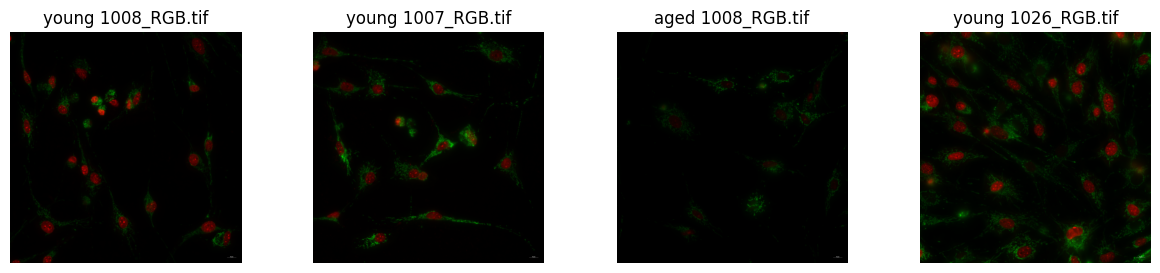

In [4]:
image_list = glob.glob(f"{image_path}/originals/*/*.tif")  # Get all images

# create figure
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 4

i = 1
while i <= columns:
  random_image = random.choice(image_list)  # Pick a random image
  image_class = Path(random_image).parent.stem
  img = cv2.imread(random_image)  # reading images

  # Adds a subplot at i position
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{Path(random_image).parent.stem} {Path(random_image).name}")
  i = i+1

And a nucleus from each type:

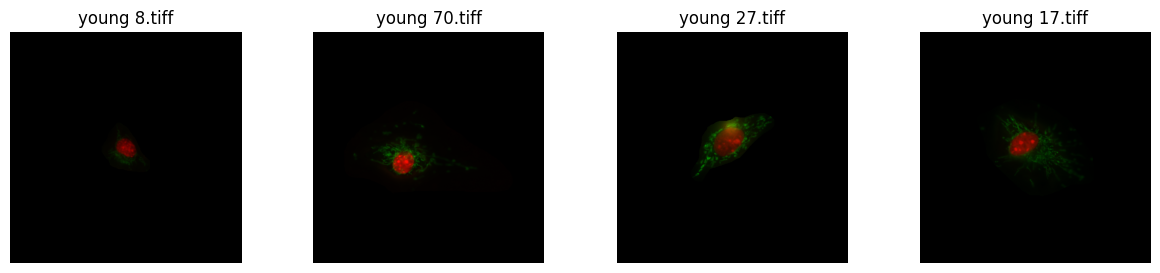

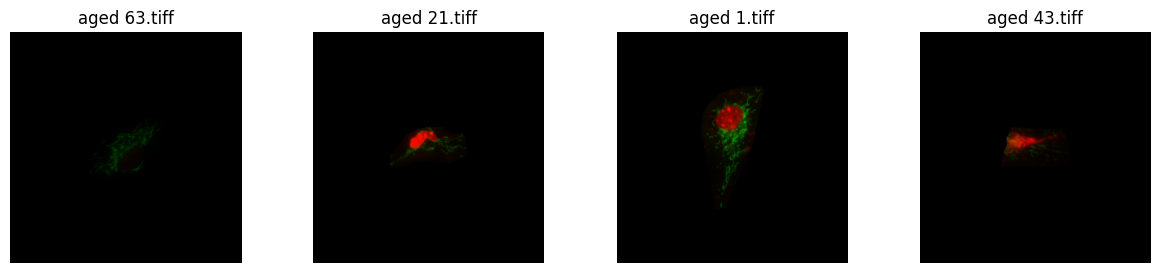

In [5]:
random.seed(sd)  # Set seed
image_list = glob.glob(f"{image_path}/nuclei/*/young/*.tiff")
random_image = random.choice(image_list)  # Pick a random image

# create figure
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 4

i = 1
while i <= columns:
  random_image = random.choice(image_list)  # Pick a random image
  image_class = Path(random_image).parent.stem
  img = cv2.imread(random_image)  # reading images

  # Adds a subplot at i position
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{Path(random_image).parent.stem} {Path(random_image).name}")
  i = i+1

image_list = glob.glob(f"{image_path}/nuclei/*/aged/*.tiff")
random_image = random.choice(image_list)  # Pick a random image

# create figure
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 4

i = 1
while i <= columns:
  random_image = random.choice(image_list)  # Pick a random image
  image_class = Path(random_image).parent.stem
  img = cv2.imread(random_image)  # reading images

  # Adds a subplot at i position
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{Path(random_image).parent.stem} {Path(random_image).name}")
  i = i+1

## Training Data
All good.  Now, let's create the training data.  For each training image, I'll send it and some rotated copies of it, to the saved dir (don't clog up google drive).

This time, try converting to .jpg

In [3]:
def rotate_image(image):
  img = Image.open(image)
  fn = Path(image)
  # rotating an image
  amt = [0, 36, 72, 108, 144, 180, 216, 252, 288, 324]
  for rot in amt:
    imR = img.rotate(rot, Image.NEAREST, expand = 1)
    imR.save(FOL + "/" + fn.parent.name + "/" + fn.stem + "-"
             + str(rot) + ".jpg", "JPEG", quality=100)

In [ ]:
image_list = glob.glob(f"{image_path}/nuclei/*/*/*.tiff")
# i = 0
for img in image_list:
  print("Rotating img", img)
  rotate_image(img)
  # if i == 3: break
  # i = i + 1

!ls

So far, so good.

Let's see how the images are structured.  If we want to do anything with the image we have to convert it to an array of data:

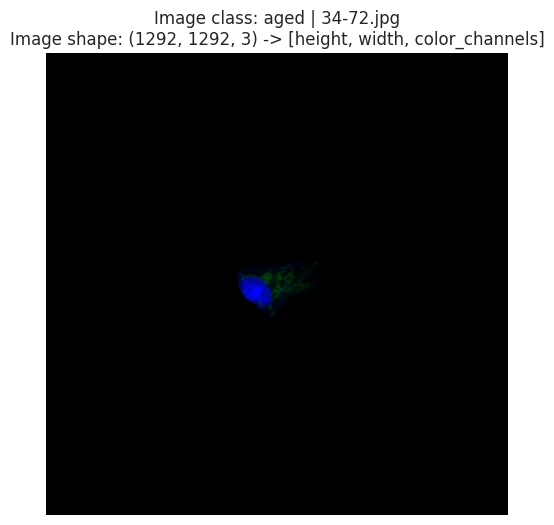

In [21]:
random.seed(sd)  # Set seed
sns.set_theme()  # because this theme is pretty

image_list = glob.glob(FOL + "/*/*.jpg")
random_image = random.choice(image_list)  # Pick a random image
img = Image.open(random_image)
# Turn the image into an array
img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {Path(random_image).parent.stem} | {Path(random_image).name}\nImage shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Set up model.


Define a transform (to resize, flip, etc)

**Perhaps brighten and sharpen?**

In [4]:
IMAGE_WIDTH = 256  # 128
IMAGE_HEIGHT = 256  # 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])
print(data_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


Plot some transformations

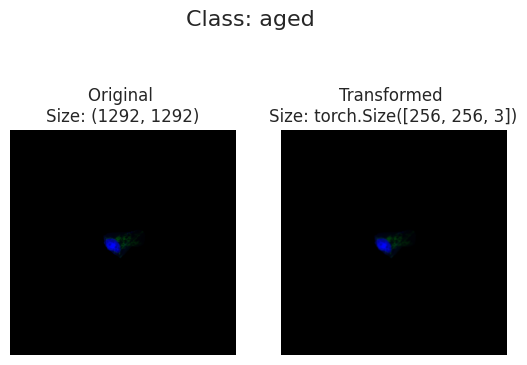

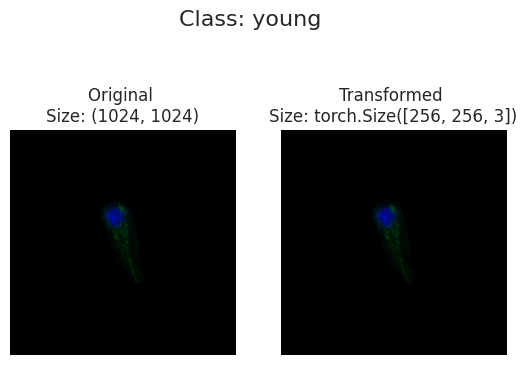

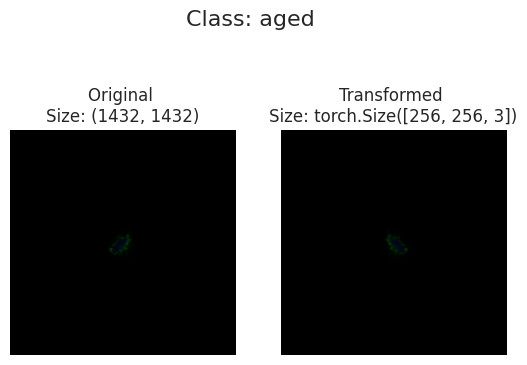

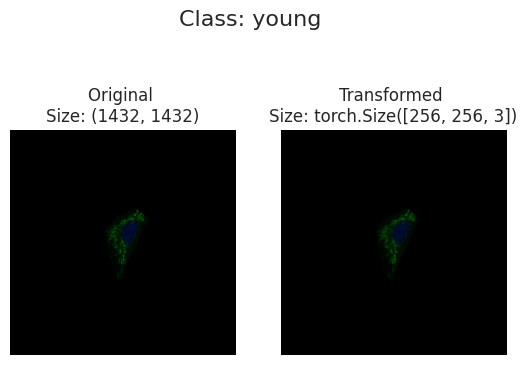

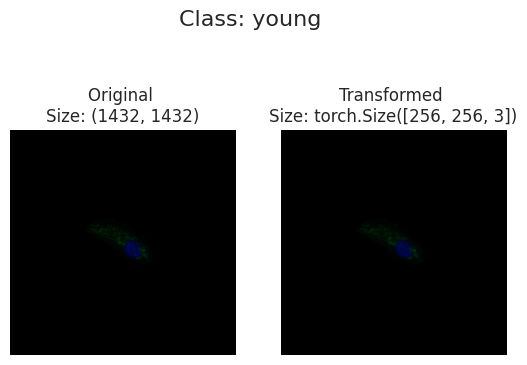

In [22]:
def plot_transformed_images(image_paths, transform, n=5, seed=42):
  random.seed(sd)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_list, transform=data_transform, n=5)

Now set up the full training set and the test image set

In [24]:
train_dir = FOL
test_dir = f'{image_path}/Test_set/'

print(f"Train data: {train_dir}\nTest data: {test_dir}\n")

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
    transform=data_transform, # transforms to perform on data (images)
    target_transform=None) # transforms to perform on labels (if necessary)
# Creating test set
test_data = datasets.ImageFolder(root=test_dir,
    transform=data_transform)

print(f"Train data:\t{train_data}\n\nTest data:\t{test_data}")

Train data: ./my_data/nucs
Test data: ./drive/My Drive/Images/Test_set/

Train data:	Dataset ImageFolder
    Number of datapoints: 1210
    Root location: ./my_data/nucs
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Test data:	Dataset ImageFolder
    Number of datapoints: 33
    Root location: ./drive/My Drive/Images/Test_set/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Gatherup some meta-data

In [25]:
# Get class names as a list
class_names = train_data.classes
print("Class names:", class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict:", class_dict)

# Check the lengths
print(f"Training set images: {len(train_data)}\nTest set images: {len(test_data)}\n")

img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}\n")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Class names: ['aged', 'young']
Class names as a dict: {'aged': 0, 'young': 1}
Training set images: 1210
Test set images: 33

Image tensor: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Image shape: torch.Size([3, 256, 256])
Image datatype: torch.float32
Image

Using MatPlotLib to vizualize the img

Original shape: torch.Size([3, 256, 256]) -> [color_channels, height, width]
Image permute shape: torch.Size([256, 256, 3]) -> [height, width, color_channels]


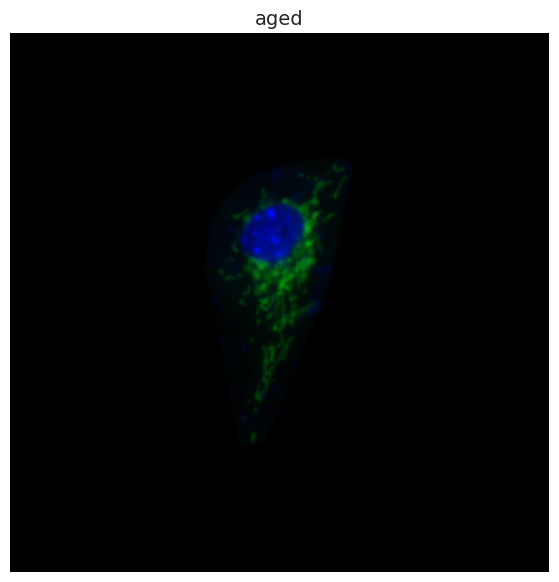

In [26]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"{class_names[label]}", fontsize=14);

In [27]:
# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=True) # don't usually need to shuffle testing data

train_dataloader, test_dataloader, NUM_WORKERS

(<torch.utils.data.dataloader.DataLoader at 0x7dbc50beac80>,
 2)

In [17]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 256, 256]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [28]:
# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 1210
     Root location: ./my_data/nucs
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 33
     Root location: ./drive/My Drive/Images/Test_set/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [29]:
# Set some parameters.
BATCH_SIZE = 32
torch.manual_seed(sd)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented, NUM_WORKERS

(<torch.utils.data.dataloader.DataLoader at 0x7dbc50ad9c00>,
 2)

In [5]:
# # Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = ImageClassifier().to(device)
model

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear

Try it out on animage:

In [30]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[0.3135, 0.5881]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4318, 0.5682]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0


Understanding the model

In [24]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

In [6]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

Ready to train model:

In [ ]:
# Set random seeds
torch.manual_seed(sd)
torch.cuda.manual_seed(sd)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

torch.save(model, image_path + '/senmodel-pretrain')

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

torch.save(model, image_path + '/senmodel-posttrain')

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [31]:
#print(f"{(end_time-start_time)/3600:.2f} hrs")
model

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear

So the model is trained . . .

Time to vizualize loss and accuracy:

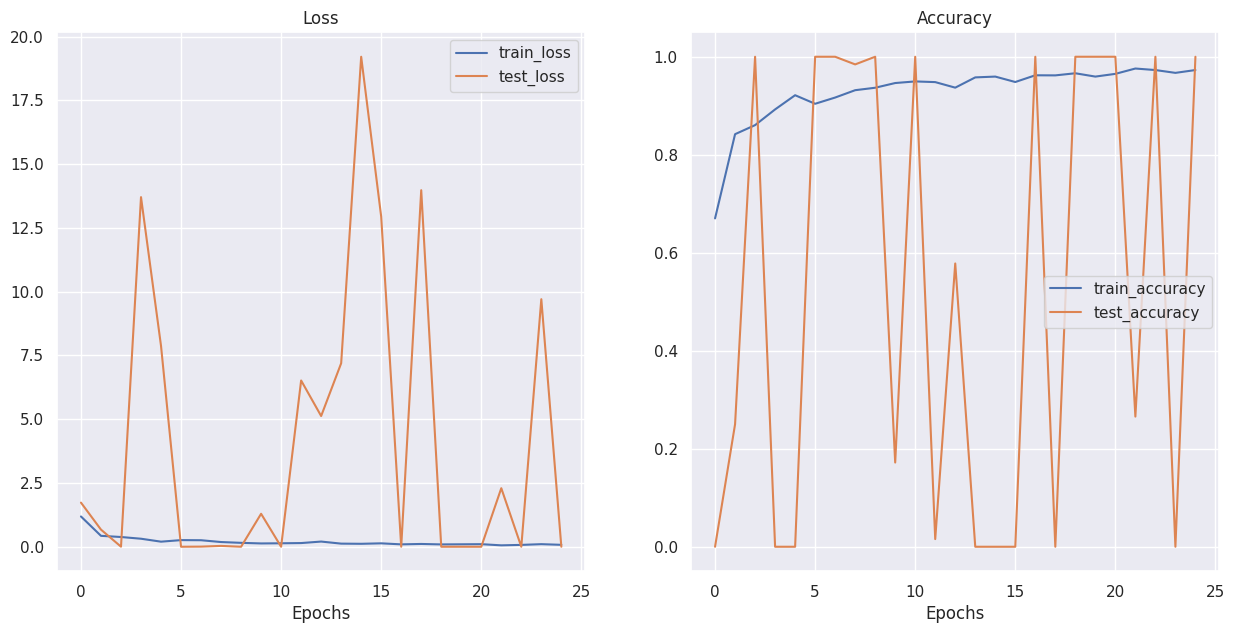

In [32]:
# visualize the loss and accuracy values
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

# Make a Prediction

Test image path: ./drive/My Drive/Images/Test_set/test_set/aged/63.tiff
Image class: aged
Image height: 1024
Image width: 1024


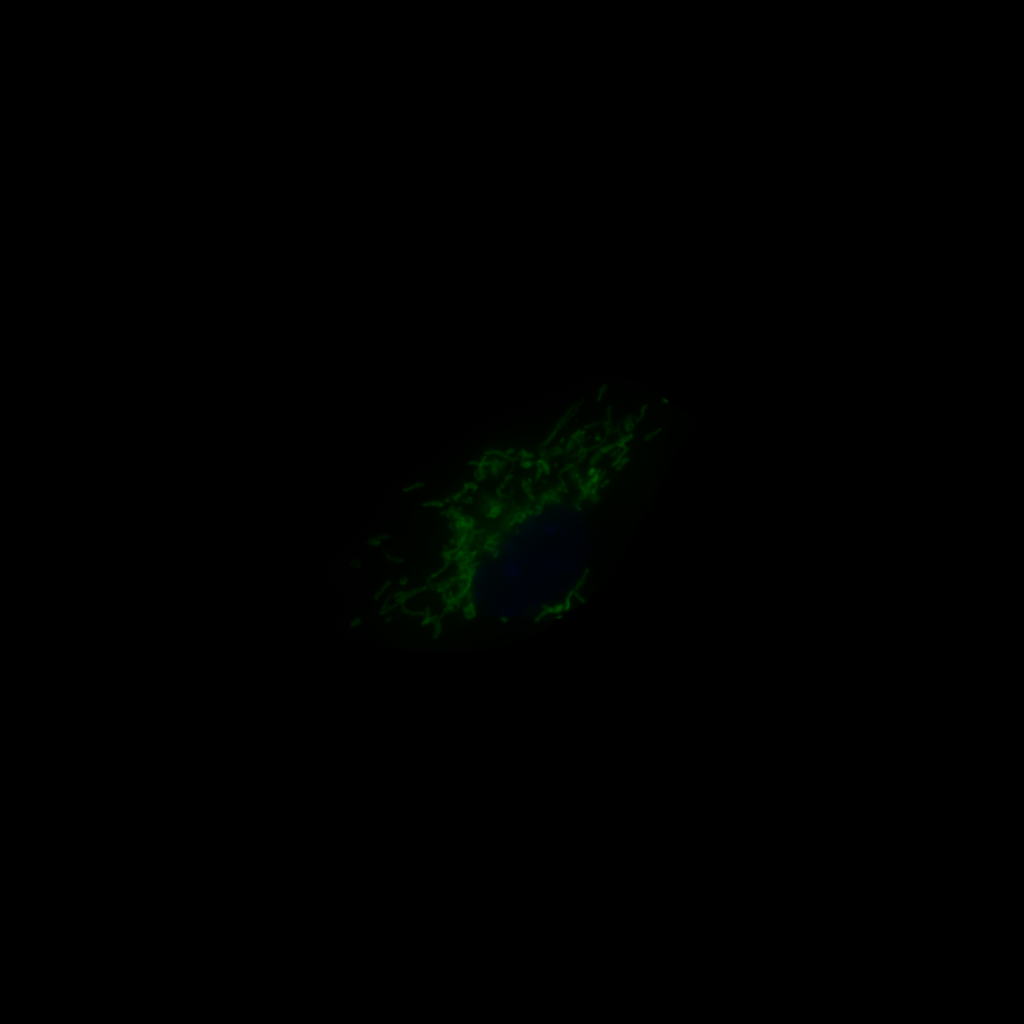

In [33]:
# Make a prediction

# Set seed
random.seed()

# Choose a test image.
# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/Test_set/*/*/*.tiff")

# 2a. Get random image path
test_image_path = random.choice(image_path_list)
# 2b. Get specific image path
#test_image_path = image_path + "/nuclei/test_set/aged/66.tiff"

# 3. Get image class from path name (the image class is the name
# of the directory where the image is stored)
image_class = Path(test_image_path).parent.stem

# 4. Open image
img = Image.open(test_image_path)

# 5. Print metadata
print(f"Test image path: {test_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [34]:
import torchvision

test_jpg = "./my_data/test"

outfile = test_jpg + "/" + Path(test_image_path).stem + "-" + Path(test_image_path).parent.stem + '.jpg'
img.save(outfile, "JPEG", quality=100)

img = Image.open(outfile)
img.filename

'./my_data/test/63-aged.jpg'

In [35]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(img.filename).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Custom image shape: torch.Size([3, 1024, 1024])

Custom image dtype: torch.float32


In [36]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1024, 1024])
New shape: torch.Size([3, 224, 224])


In [37]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [38]:
custom_image_pred

tensor([[0.1780, 0.2088]], device='cuda:0')

In [39]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[0.1780, 0.2088]], device='cuda:0')
Prediction probabilities: tensor([[0.4923, 0.5077]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


In [40]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'young'

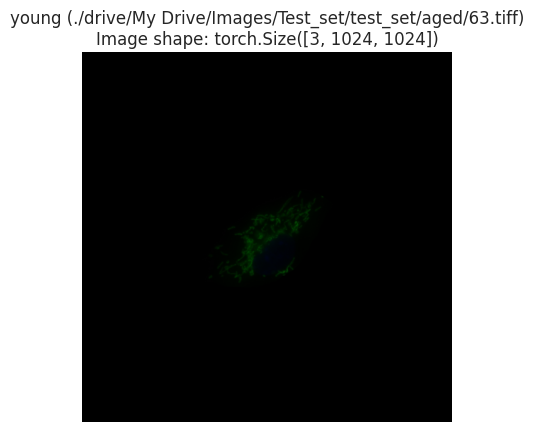

In [41]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"{custom_image_pred_class} ({test_image_path})\nImage shape: {custom_image.shape}")
plt.axis(False);

# Test all Test Images:

In [43]:
# Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/Test_set/test_set/*/*.tiff")

numImages = 0
numCorrect = 0
numWrong = 0

# Get each image
for test_image in image_path_list:
    # Get image class from path name
    image_class = Path(test_image).parent.stem
    # Open image
    img = Image.open(test_image)
    # Print metadata
    #print(f"Test image: {test_image}")

    outfile = test_jpg + "/" + Path(test_image).stem + "-" + Path(test_image).parent.stem + '.jpg'
    img.save(outfile, "JPEG", quality=100)

    imT = Image.open(outfile)
    #print(imT.filename)

    # Load in custom image and convert the tensor values to float32
    custom_image = torchvision.io.read_image(imT.filename).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    custom_image = custom_image / 255.

    # Print out image data
    # print(f"Custom image tensor:\n{custom_image}\n")
    # print(f"Custom image shape: {custom_image.shape}\n")
    # print(f"Custom image dtype: {custom_image.dtype}")

    custom_image_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
    ])

    # Transform target image
    custom_image_transformed = custom_image_transform(custom_image)

    # Print out original shape and new shape
    # print(f"Original shape: {custom_image.shape}")
    # print(f"New shape: {custom_image_transformed.shape}")

    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to image
        custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

        # Print out different shapes
        # print(f"Custom image transformed shape: {custom_image_transformed.shape}")
        # print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

        # Make a prediction on image with an extra dimension
        custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    #print(imT.filename, custom_image_pred)

    # Let's convert them from logits -> prediction probabilities -> prediction labels
    # Print out prediction logits
    #print(f"Prediction logits: {custom_image_pred}")

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    #print(f"Prediction probabilities: {custom_image_pred_probs}")

    # Convert prediction probabilities -> prediction labels
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
    #print(f"Prediction label: {custom_image_pred_label}")

    custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
    print(Path(imT.filename).name, image_class, custom_image_pred_class)

    # Plot custom image
    # plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
    # plt.title(f"{custom_image_pred_class} ({test_image_path})\nImage shape: {custom_image.shape}")
    # plt.axis(False);

    numImages = numImages + 1

    if image_class == custom_image_pred_class:
        numCorrect = numCorrect + 1
    else:
        numWrong = numWrong + 1

    if numImages == 10 : continue  # break
# imT
print(f"\nNumber Images: {numImages} Correct: {numCorrect} Wrong: {numWrong}")

76-aged.jpg aged aged
75-aged.jpg aged aged
74-aged.jpg aged young
73-aged.jpg aged aged
72-aged.jpg aged aged
71-aged.jpg aged aged
70-aged.jpg aged aged
69-aged.jpg aged aged
68-aged.jpg aged aged
67-aged.jpg aged aged
66-aged.jpg aged aged
65-aged.jpg aged young
64-aged.jpg aged aged
63-aged.jpg aged young
62-aged.jpg aged aged
61-aged.jpg aged young
74-young.jpg young young
73-young.jpg young young
72-young.jpg young young
71-young.jpg young young
70-young.jpg young aged
69-young.jpg young young
68-young.jpg young young
67-young.jpg young young
66-young.jpg young young
65-young.jpg young young
64-young.jpg young young
63-young.jpg young aged
62-young.jpg young young
61-young.jpg young young

Number Images: 30 Correct: 24 Wrong: 6


In [44]:
# Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.tiff")

numImages = 0
numCorrect = 0
numWrong = 0

# Get each image
for test_image in image_path_list:
    # Get image class from path name
    image_class = Path(test_image).parent.stem
    # Open image
    img = Image.open(test_image)
    # Print metadata
    #print(f"Test image: {test_image}")

    outfile = test_jpg + "/" + Path(test_image).stem + "-" + Path(test_image).parent.stem + '.jpg'
    img.save(outfile, "JPEG", quality=100)

    imT = Image.open(outfile)
    #print(imT.filename)

    # Load in custom image and convert the tensor values to float32
    custom_image = torchvision.io.read_image(imT.filename).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    custom_image = custom_image / 255.

    # Print out image data
    # print(f"Custom image tensor:\n{custom_image}\n")
    # print(f"Custom image shape: {custom_image.shape}\n")
    # print(f"Custom image dtype: {custom_image.dtype}")

    custom_image_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
    ])

    # Transform target image
    custom_image_transformed = custom_image_transform(custom_image)

    # Print out original shape and new shape
    # print(f"Original shape: {custom_image.shape}")
    # print(f"New shape: {custom_image_transformed.shape}")

    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to image
        custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

        # Print out different shapes
        # print(f"Custom image transformed shape: {custom_image_transformed.shape}")
        # print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

        # Make a prediction on image with an extra dimension
        custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    #print(imT.filename, custom_image_pred)

    # Let's convert them from logits -> prediction probabilities -> prediction labels
    # Print out prediction logits
    #print(f"Prediction logits: {custom_image_pred}")

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    #print(f"Prediction probabilities: {custom_image_pred_probs}")

    # Convert prediction probabilities -> prediction labels
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
    #print(f"Prediction label: {custom_image_pred_label}")

    custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
    print(Path(imT.filename).name, image_class, custom_image_pred_class)

    # Plot custom image
    # plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
    # plt.title(f"{custom_image_pred_class} ({test_image_path})\nImage shape: {custom_image.shape}")
    # plt.axis(False);

    numImages = numImages + 1

    if image_class == custom_image_pred_class:
        numCorrect = numCorrect + 1
    else:
        numWrong = numWrong + 1

    if numImages == 10 : continue  # break
# imT
print(f"\nNumber Images: {numImages} Correct: {numCorrect} Wrong: {numWrong}")

53-aged.jpg aged young
29-aged.jpg aged young
8-aged.jpg aged young
19-aged.jpg aged young
60-aged.jpg aged aged
59-aged.jpg aged aged
58-aged.jpg aged aged
57-aged.jpg aged aged
56-aged.jpg aged aged
55-aged.jpg aged aged
54-aged.jpg aged aged
52-aged.jpg aged young
51-aged.jpg aged young
50-aged.jpg aged young
49-aged.jpg aged young
47-aged.jpg aged aged
48-aged.jpg aged young
46-aged.jpg aged aged
45-aged.jpg aged young
44-aged.jpg aged young
43-aged.jpg aged young
42-aged.jpg aged young
41-aged.jpg aged aged
40-aged.jpg aged young
39-aged.jpg aged young
38-aged.jpg aged young
37-aged.jpg aged young
36-aged.jpg aged young
35-aged.jpg aged aged
34-aged.jpg aged young
33-aged.jpg aged young
32-aged.jpg aged young
31-aged.jpg aged young
30-aged.jpg aged aged
28-aged.jpg aged young
27-aged.jpg aged young
26-aged.jpg aged young
25-aged.jpg aged young
24-aged.jpg aged young
23-aged.jpg aged young
20-aged.jpg aged young
22-aged.jpg aged young
21-aged.jpg aged young
w0-aged.jpg aged aged
18

OK, try again - but with JUST the training data:

In [8]:
image_list = glob.glob(f"{image_path}/nuclei/training_set/*/*.tiff")

print(image_list)

for img in image_list:
  print("Rotating img", img)
  rotate_image(img)

!ls

train_dir = FOL
test_dir = f'{image_path}/Test_set'

print(f"Train data: {train_dir}\nTest data: {test_dir}\n")

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
    transform=data_transform, # transforms to perform on data (images)
    target_transform=None) # transforms to perform on labels (if necessary)
# Creating test set
test_data = datasets.ImageFolder(root=test_dir,
    transform=data_transform)

print(f"Train data:\t{train_data}\n\nTest data:\t{test_data}")

['./drive/My Drive/Images/nuclei/training_set/aged/53.tiff', './drive/My Drive/Images/nuclei/training_set/aged/29.tiff', './drive/My Drive/Images/nuclei/training_set/aged/8.tiff', './drive/My Drive/Images/nuclei/training_set/aged/19.tiff', './drive/My Drive/Images/nuclei/training_set/aged/60.tiff', './drive/My Drive/Images/nuclei/training_set/aged/59.tiff', './drive/My Drive/Images/nuclei/training_set/aged/58.tiff', './drive/My Drive/Images/nuclei/training_set/aged/57.tiff', './drive/My Drive/Images/nuclei/training_set/aged/56.tiff', './drive/My Drive/Images/nuclei/training_set/aged/55.tiff', './drive/My Drive/Images/nuclei/training_set/aged/54.tiff', './drive/My Drive/Images/nuclei/training_set/aged/52.tiff', './drive/My Drive/Images/nuclei/training_set/aged/51.tiff', './drive/My Drive/Images/nuclei/training_set/aged/50.tiff', './drive/My Drive/Images/nuclei/training_set/aged/49.tiff', './drive/My Drive/Images/nuclei/training_set/aged/47.tiff', './drive/My Drive/Images/nuclei/training

In [48]:
# Get class names as a list
class_names = train_data.classes
print("Class names:", class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict:", class_dict)

# Check the lengths
print(f"Training set images: {len(train_data)}\nTest set images: {len(test_data)}\n")

img, label = train_data[0][0], train_data[0][1]

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
# print(f"Original shape: {img.shape} -> [color_channels, height, width]")
# print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=True) # don't usually need to shuffle testing data

# Instantiate an object.
model2 = ImageClassifier().to(device)
# print(model2)

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

# print(train_data_augmented, test_data_augmented)

# Set some parameters.
BATCH_SIZE = 32
torch.manual_seed(sd)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS)

# print(train_dataloader_augmented, test_dataloader_augmented, NUM_WORKERS)

# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model2.eval()
with torch.inference_mode():
    pred = model2(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}\n\n")

# summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

Class names: ['aged', 'young']
Class names as a dict: {'aged': 0, 'young': 1}
Training set images: 1210
Test set images: 33

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0036,  0.0065]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4975, 0.5025]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0




In [13]:
# Set random seeds
torch.manual_seed(sd)
torch.cuda.manual_seed(sd)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

torch.save(model2, image_path + '/senmodel2-pretrain')

# Train model_0
model_results = train(model=model2,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

torch.save(model2, image_path + '/senmodel2-posttrain')

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1869 | train_acc: 0.6701 | test_loss: 1.7304 | test_acc: 0.0000
Epoch: 2 | train_loss: 0.4280 | train_acc: 0.8420 | test_loss: 0.6715 | test_acc: 0.2500
Epoch: 3 | train_loss: 0.3819 | train_acc: 0.8605 | test_loss: 0.0030 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.3146 | train_acc: 0.8925 | test_loss: 13.7041 | test_acc: 0.0000
Epoch: 5 | train_loss: 0.1991 | train_acc: 0.9215 | test_loss: 7.8722 | test_acc: 0.0000
Epoch: 6 | train_loss: 0.2602 | train_acc: 0.9040 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.2556 | train_acc: 0.9168 | test_loss: 0.0051 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.1846 | train_acc: 0.9317 | test_loss: 0.0333 | test_acc: 0.9844
Epoch: 9 | train_loss: 0.1534 | train_acc: 0.9367 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.1298 | train_acc: 0.9464 | test_loss: 1.2924 | test_acc: 0.1719
Epoch: 11 | train_loss: 0.1358 | train_acc: 0.9496 | test_loss: 0.0002 | test_acc: 1.0000
Epoch: 12 | train_

In [49]:
import torchvision

# Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/Test_set/test_set/*/*.tiff")

numImages = 0
numCorrect = 0
numWrong = 0

# Get each image
for test_image in image_path_list:
    # Get image class from path name
    image_class = Path(test_image).parent.stem
    # Open image
    img = Image.open(test_image)
    # Print metadata
    #print(f"Test image: {test_image}")

    outfile = "./my_data/test/" + Path(test_image).stem + "-" + Path(test_image).parent.stem + '.jpg'
    img.save(outfile, "JPEG", quality=100)

    imT = Image.open(outfile)
    #print(imT.filename)

    # Load in custom image and convert the tensor values to float32
    custom_image = torchvision.io.read_image(imT.filename).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    custom_image = custom_image / 255.

    # Print out image data
    # print(f"Custom image tensor:\n{custom_image}\n")
    # print(f"Custom image shape: {custom_image.shape}\n")
    # print(f"Custom image dtype: {custom_image.dtype}")

    custom_image_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
    ])

    # Transform target image
    custom_image_transformed = custom_image_transform(custom_image)

    # Print out original shape and new shape
    # print(f"Original shape: {custom_image.shape}")
    # print(f"New shape: {custom_image_transformed.shape}")

    model2.eval()
    with torch.inference_mode():
        # Add an extra dimension to image
        custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

        # Print out different shapes
        # print(f"Custom image transformed shape: {custom_image_transformed.shape}")
        # print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

        # Make a prediction on image with an extra dimension
        custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    #print(imT.filename, custom_image_pred)

    # Let's convert them from logits -> prediction probabilities -> prediction labels
    # Print out prediction logits
    #print(f"Prediction logits: {custom_image_pred}")

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    #print(f"Prediction probabilities: {custom_image_pred_probs}")

    # Convert prediction probabilities -> prediction labels
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
    #print(f"Prediction label: {custom_image_pred_label}")

    custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
    print(Path(imT.filename).name, image_class, custom_image_pred_class)

    # Plot custom image
    # plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
    # plt.title(f"{custom_image_pred_class} ({test_image_path})\nImage shape: {custom_image.shape}")
    # plt.axis(False);

    numImages = numImages + 1

    if image_class == custom_image_pred_class:
        numCorrect = numCorrect + 1
    else:
        numWrong = numWrong + 1

    # if numImages == 10 : continue  # break
# imT
print(f"\nNumber Images: {numImages} Correct: {numCorrect} Wrong: {numWrong}")

76-aged.jpg aged aged
75-aged.jpg aged aged
74-aged.jpg aged young
73-aged.jpg aged aged
72-aged.jpg aged aged
71-aged.jpg aged aged
70-aged.jpg aged aged
69-aged.jpg aged aged
68-aged.jpg aged aged
67-aged.jpg aged aged
66-aged.jpg aged aged
65-aged.jpg aged young
64-aged.jpg aged aged
63-aged.jpg aged young
62-aged.jpg aged aged
61-aged.jpg aged young
74-young.jpg young young
73-young.jpg young young
72-young.jpg young young
71-young.jpg young young
70-young.jpg young aged
69-young.jpg young young
68-young.jpg young young
67-young.jpg young young
66-young.jpg young young
65-young.jpg young young
64-young.jpg young young
63-young.jpg young aged
62-young.jpg young young
61-young.jpg young young

Number Images: 30 Correct: 24 Wrong: 6
